# Low-Pass Filtering IMU Sample Data
This notebook loads the synthetic Sensor data from the Seeed Studio XIAO nRF52840 Sense Plus, applies a simple first-order low-pass filter to the motion signals, and visualizes the noise reduction.

## Imports and Configuration
We'll use pandas/numpy for data wrangling and Matplotlib for visualization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8')


## Load the IMU Sample
The CSV stores 10 seconds of data sampled at 50 Hz.

In [3]:
DATA_PATH = Path('/Users/erickli/GitRepos/Machine-Learning-for-Smart-Fitness-Pod/data/raw/2025-12-23T16:10:21.032086_athlete1_squat_25.csv')
FS = 100.0  # sampling frequency in Hz for the wrist IMU

df = pd.read_csv(DATA_PATH)
df.head()


,Timestamp,Acceleration_X,Acceleration_Y,Acceleration_Z,Gyro_X,Gyro_Y,Gyro_Z
0,2025-12-23T16:10:21.032086,9.791430,-2.067398,1.172483,-0.085521,-0.021991,0.009773
1,2025-12-23T16:10:21.042086,9.824929,-2.009970,1.205982,-0.061086,-0.015882,0.010995
2,2025-12-23T16:10:21.051086,9.839286,-2.029113,1.191625,-0.036651,-0.006108,0.015882
3,2025-12-23T16:10:21.061086,9.762716,-2.005185,1.215553,-0.020769,-0.002443,0.021991
4,2025-12-23T16:10:21.070086,9.748359,-1.986042,1.282552,-0.014660,-0.002443,0.023212


## Define a Low-Pass Filter
We implement a first-order infinite impulse response (IIR) low-pass filter based on an RC network. It attenuates frequencies above the chosen cutoff while preserving lower-frequency motion.

In [18]:
def low_pass_filter(signal: np.ndarray, cutoff_hz: float, fs: float) -> np.ndarray:
    """Apply a simple first-order low-pass filter."""
    dt = 1.0 / fs
    rc = 1.0 / (2 * np.pi * cutoff_hz)
    alpha = dt / (rc + dt)
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    for i in range(1, len(signal)):
        filtered[i] = filtered[i - 1] + alpha * (signal[i] - filtered[i - 1])
    return filtered

cutoff_hz = 3.0  # adjust based on how aggressive you want the smoothing
columns_to_filter = [
    'Acceleration_X', 'Acceleration_Y', 'Acceleration_Z',
    'Gyro_X', 'Gyro_Y', 'Gyro_Z'
]


filtered_df = df.copy()
for column in columns_to_filter:
    filtered_df[column] = low_pass_filter(df[column].to_numpy(), cutoff_hz, FS)


## Compare Raw vs Filtered Signals
We'll plot accelerometer and gyroscope data to see the smoothing effect of the filter.

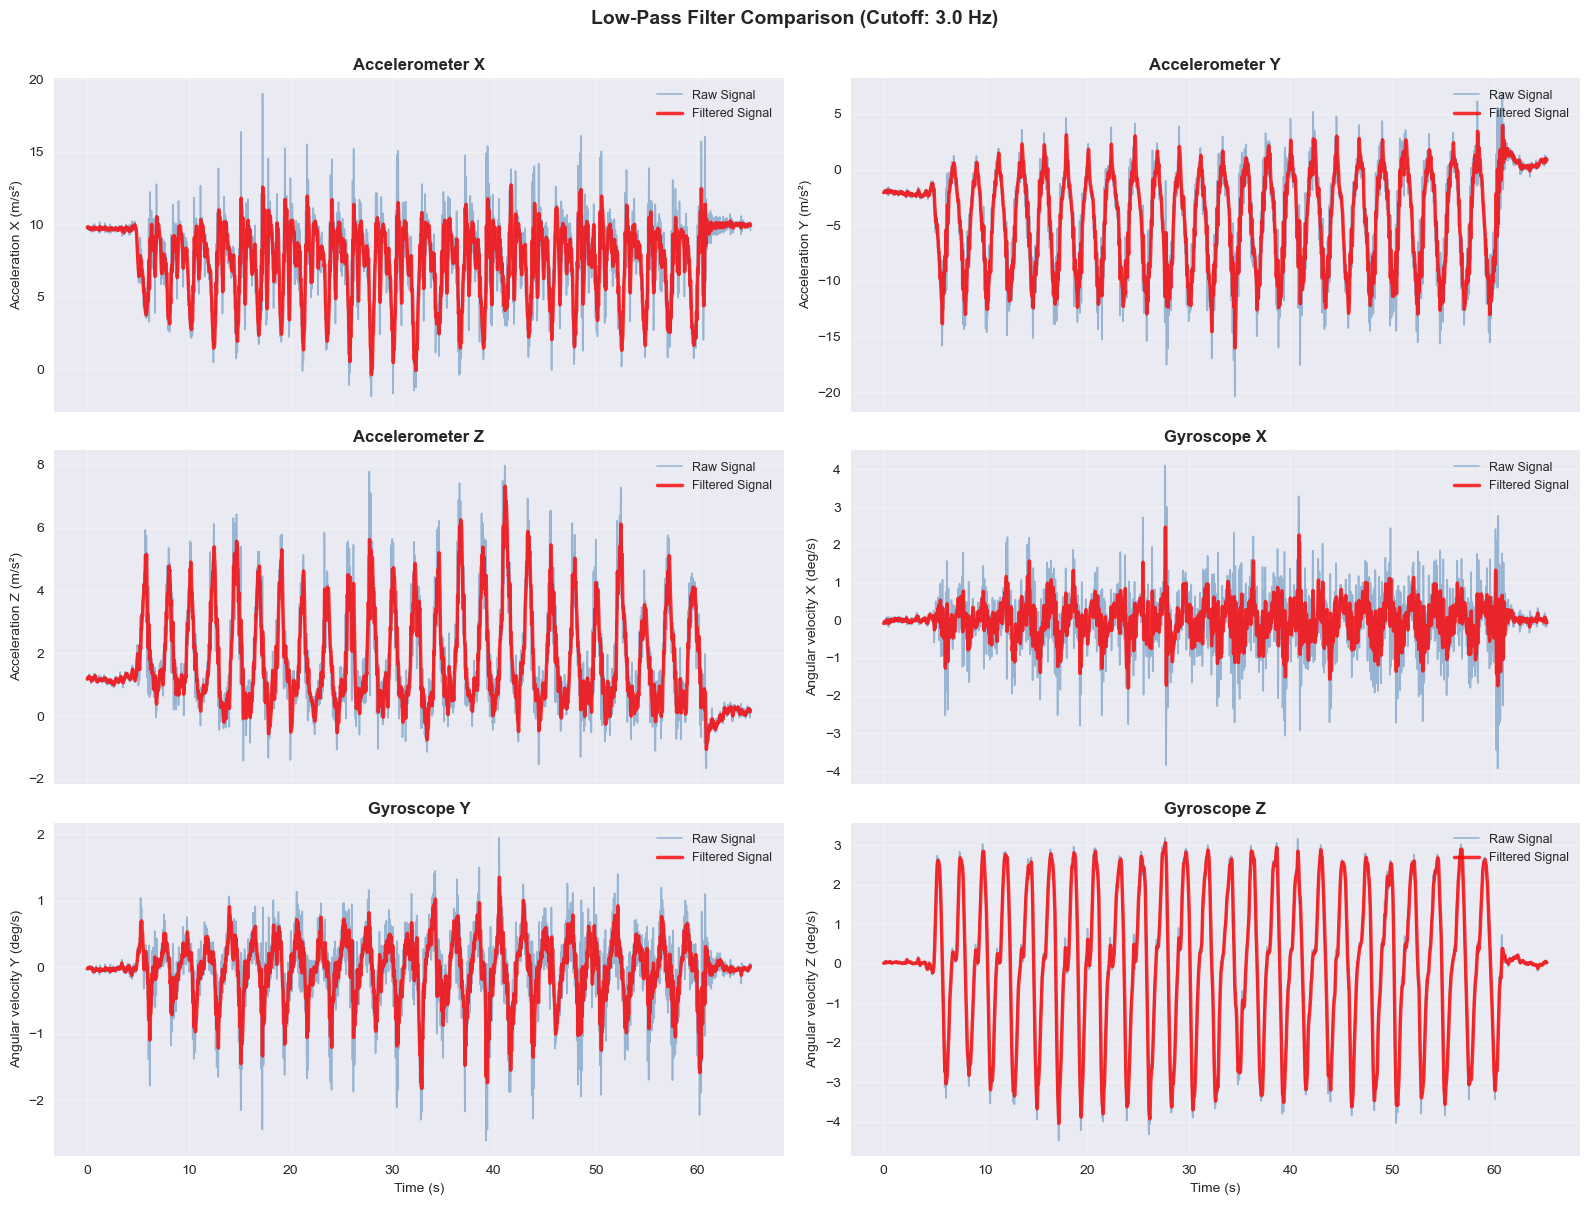

In [19]:
time_s = df.index / FS  # 使用索引作为时间

axis_configs = [
    ('Acceleration_X', 'Acceleration X (m/s²)', 'Accelerometer X'),
    ('Acceleration_Y', 'Acceleration Y (m/s²)', 'Accelerometer Y'),
    ('Acceleration_Z', 'Acceleration Z (m/s²)', 'Accelerometer Z'),
    ('Gyro_X', 'Angular velocity X (deg/s)', 'Gyroscope X'),
    ('Gyro_Y', 'Angular velocity Y (deg/s)', 'Gyroscope Y'),
    ('Gyro_Z', 'Angular velocity Z (deg/s)', 'Gyroscope Z'),
]

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, (column, ylabel, title) in zip(axes, axis_configs):
    # 绘制原始信号（半透明）
    ax.plot(time_s, df[column], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
    # 绘制滤波后的信号（粗线条）
    ax.plot(time_s, filtered_df[column], label='Filtered Signal', linewidth=2.5, color='red', alpha=0.8)
    
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

for ax in axes[-2:]:
    ax.set_xlabel('Time (s)', fontsize=10)

fig.suptitle(f'Low-Pass Filter Comparison (Cutoff: {cutoff_hz} Hz)', fontsize=14, fontweight='bold', y=1.00)
fig.tight_layout()
plt.show()

## Detailed Individual Plots
Below are detailed visualizations for each signal axis to better observe the filtering effect.

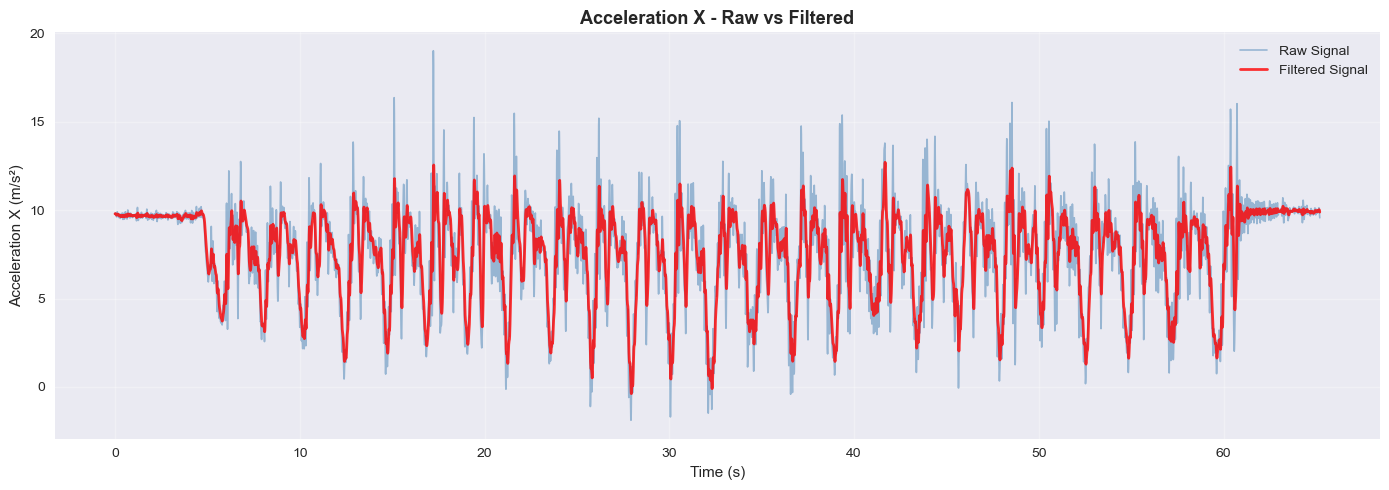

In [20]:
# Acceleration X
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time_s, df['Acceleration_X'], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
ax.plot(time_s, filtered_df['Acceleration_X'], label='Filtered Signal', linewidth=2, color='red', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Acceleration X (m/s²)', fontsize=11)
ax.set_title('Acceleration X - Raw vs Filtered', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

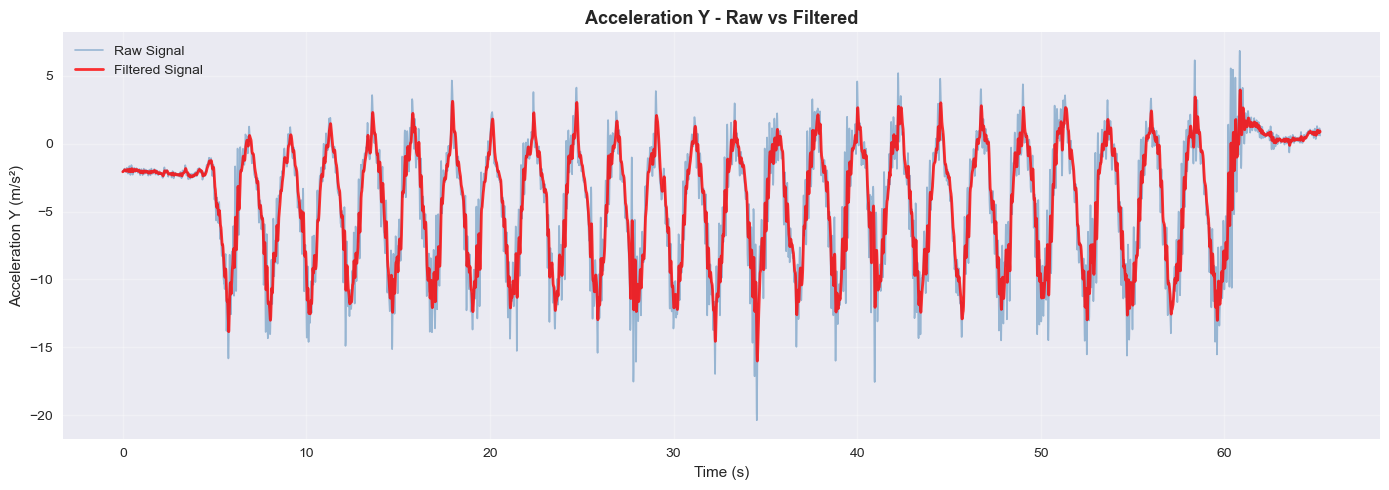

In [21]:
# Acceleration Y
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time_s, df['Acceleration_Y'], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
ax.plot(time_s, filtered_df['Acceleration_Y'], label='Filtered Signal', linewidth=2, color='red', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Acceleration Y (m/s²)', fontsize=11)
ax.set_title('Acceleration Y - Raw vs Filtered', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

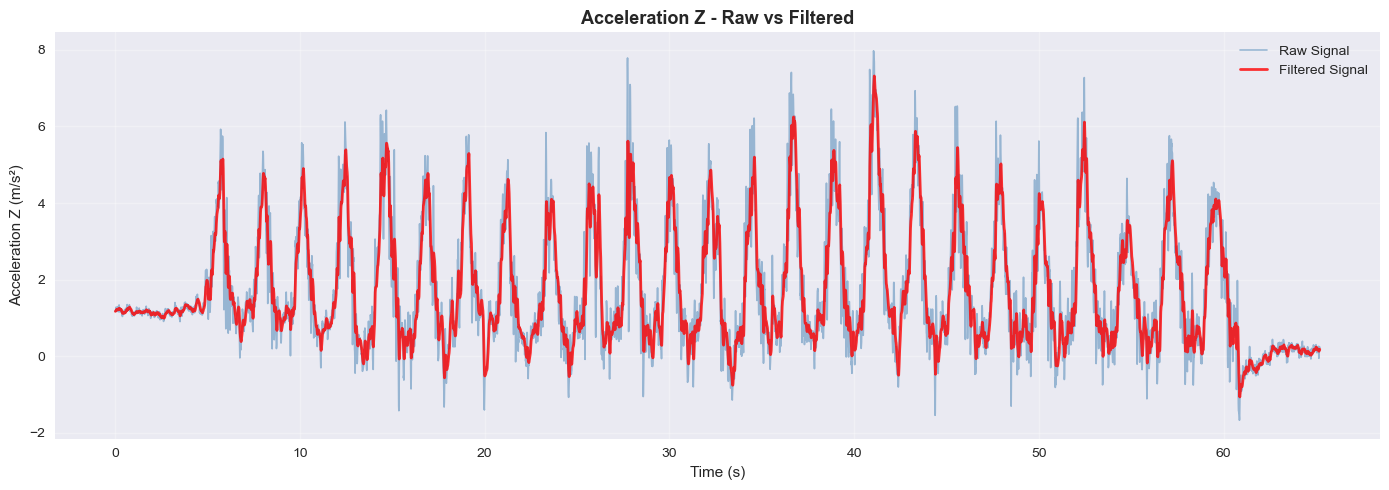

In [22]:
# Acceleration Z
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time_s, df['Acceleration_Z'], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
ax.plot(time_s, filtered_df['Acceleration_Z'], label='Filtered Signal', linewidth=2, color='red', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Acceleration Z (m/s²)', fontsize=11)
ax.set_title('Acceleration Z - Raw vs Filtered', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

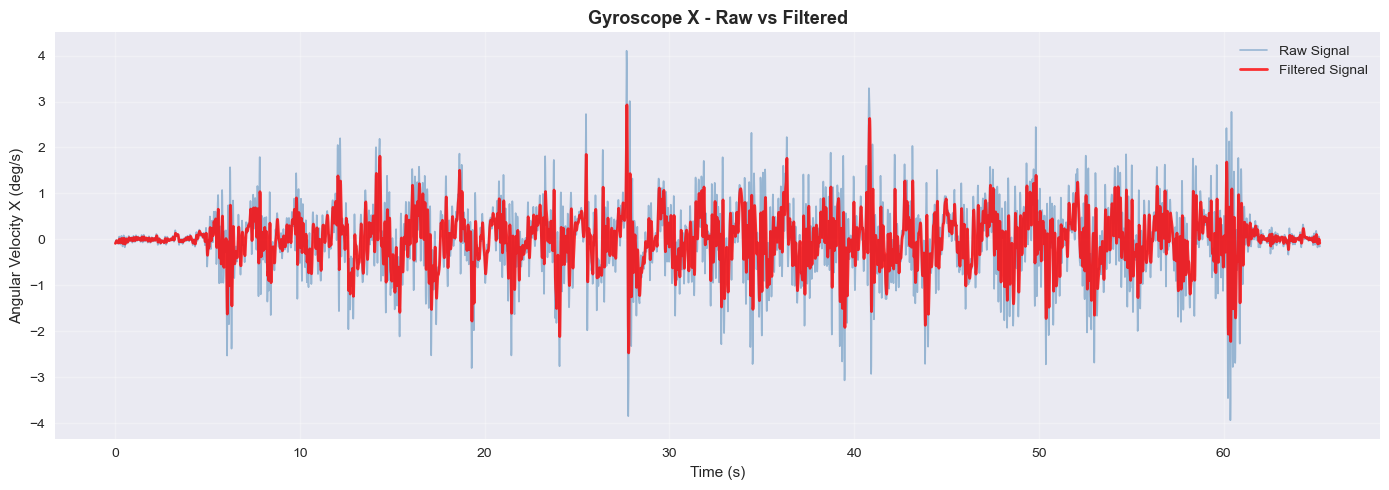

In [9]:
# Gyro X
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time_s, df['Gyro_X'], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
ax.plot(time_s, filtered_df['Gyro_X'], label='Filtered Signal', linewidth=2, color='red', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Angular Velocity X (deg/s)', fontsize=11)
ax.set_title('Gyroscope X - Raw vs Filtered', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

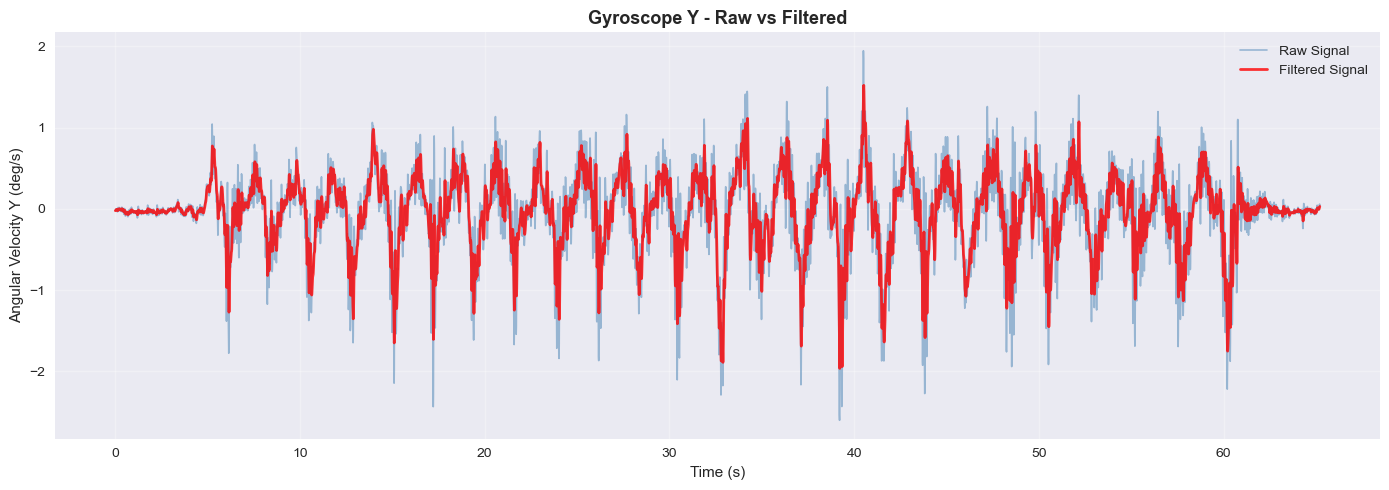

In [10]:
# Gyro Y
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time_s, df['Gyro_Y'], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
ax.plot(time_s, filtered_df['Gyro_Y'], label='Filtered Signal', linewidth=2, color='red', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Angular Velocity Y (deg/s)', fontsize=11)
ax.set_title('Gyroscope Y - Raw vs Filtered', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

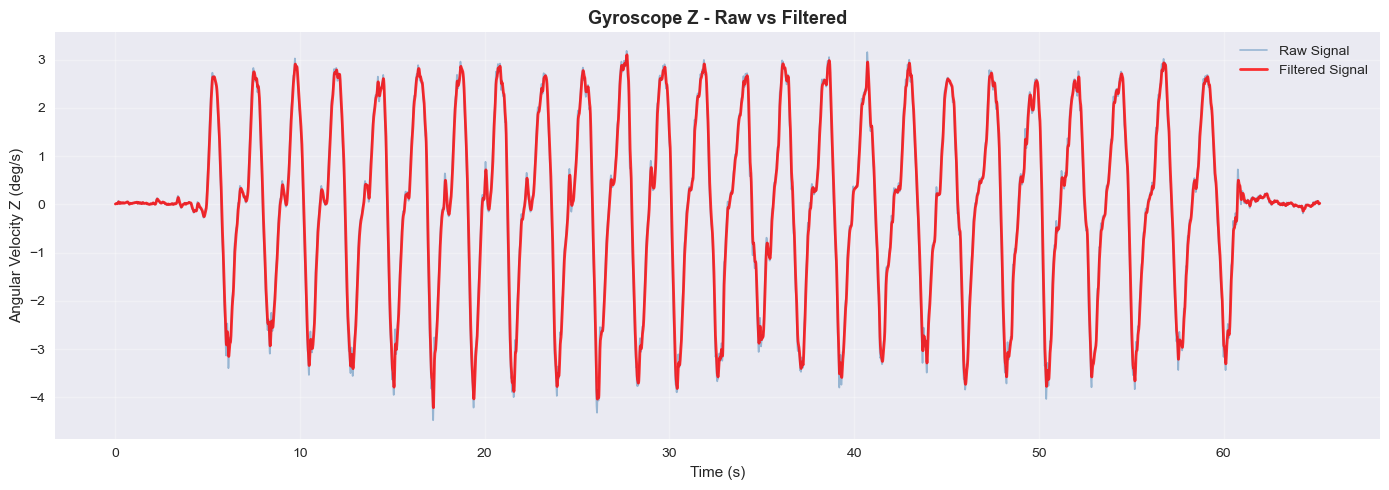

In [11]:
# Gyro Z
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(time_s, df['Gyro_Z'], label='Raw Signal', alpha=0.5, linewidth=1.2, color='steelblue')
ax.plot(time_s, filtered_df['Gyro_Z'], label='Filtered Signal', linewidth=2, color='red', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Angular Velocity Z (deg/s)', fontsize=11)
ax.set_title('Gyroscope Z - Raw vs Filtered', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Save Filtered Output (Optional)
You can persist the filtered signals for downstream processing.

In [ ]:
OUTPUT_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/processed/filtered.csv')
filtered_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH

: 